# Advanced kriging

In this example we will build a metamodel using gaussian process regression of the $x\sin(x)$ function.

We will choose the number of learning points, the basis and the covariance model.


In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
import matplotlib.pyplot as plt

## Generate design of experiment

We create training samples from the function $x\sin(x)$. We can change their number and distribution in the $[0; 10]$ range.
If the `with_error` boolean is `True`, then the data is computed by adding a gaussian noise to the function values.

In [2]:
dim = 1
xmin = 0 
xmax = 10
n_pt = 20 # number of initial points
with_error = True  # whether to use generation with error

In [3]:
ref_func_with_error = ot.SymbolicFunction(['x', 'eps'], ['x * sin(x) + eps'])
ref_func = ot.ParametricFunction(ref_func_with_error, [1], [0.0])
x = np.vstack(np.linspace(xmin, xmax, n_pt))
ot.RandomGenerator.SetSeed(1235)
eps = ot.Normal(0, 1.5).getSample(n_pt)
X = ot.Sample(n_pt, 2)
X[:, 0] = x
X[:, 1] = eps
if with_error:
    y = np.array(ref_func_with_error(X))
else:
    y = np.array(ref_func(x))

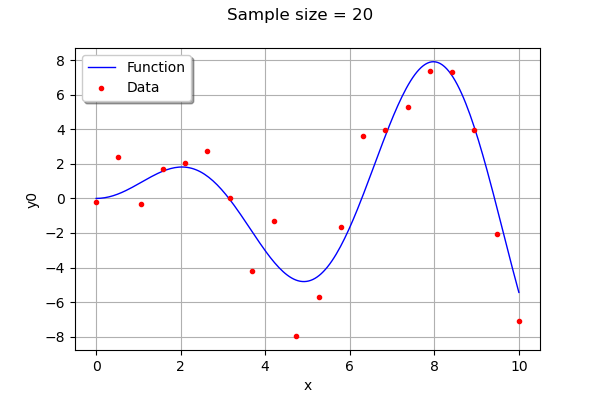

In [4]:
graph = ref_func.draw(xmin, xmax, 200)
cloud = ot.Cloud(x, y)
cloud.setColor('red')
cloud.setPointStyle('bullet')
graph.add(cloud)
graph.setLegends(["Function","Data"])
graph.setLegendPosition("topleft")
graph.setTitle("Sample size = %d" % (n_pt))
graph

## Create the kriging algorithm

In [5]:
# 1. basis
ot.ResourceMap.SetAsBool('GeneralLinearModelAlgorithm-UseAnalyticalAmplitudeEstimate', True)
basis = ot.ConstantBasisFactory(dim).build()
print(basis)

# 2. covariance model
cov = ot.MaternModel([1.], [2.5], 1.5)
print(cov)

# 3. kriging algorithm
algokriging = ot.KrigingAlgorithm(x, y, cov, basis)

## error measure
#algokriging.setNoise([5*1e-1]*n_pt)

# 4. Optimization
# algokriging.setOptimizationAlgorithm(ot.NLopt('GN_DIRECT'))
startingPoint = ot.LHSExperiment(ot.Uniform(1e-1, 1e2), 50).generate()
algokriging.setOptimizationAlgorithm(ot.MultiStart(ot.TNC(), startingPoint))
algokriging.setOptimizationBounds(ot.Interval([0.1], [1e2]))

# if we choose not to optimize parameters
#algokriging.setOptimizeParameters(False)

# 5. run the algorithm
algokriging.run()

Basis( [class=LinearEvaluation name=Unnamed center=[0] constant=[1] linear=[[ 0 ]]] )
MaternModel(scale=[1], amplitude=[2.5], nu=1.5)


## Results

In [6]:
# get some results
krigingResult = algokriging.getResult()
print('residual = ', krigingResult.getResiduals())
print('R2 = ', krigingResult.getRelativeErrors())
print('Optimal scale= {}'.format(krigingResult.getCovarianceModel().getScale()))
print('Optimal amplitude = {}'.format(krigingResult.getCovarianceModel().getAmplitude()))
print('Optimal trend coefficients = {}'.format(krigingResult.getTrendCoefficients()))

residual =  [3.50745e-16]
R2 =  [1.26609e-31]
Optimal scale= [0.818671]
Optimal amplitude = [4.51225]
Optimal trend coefficients = [[-0.115697]]


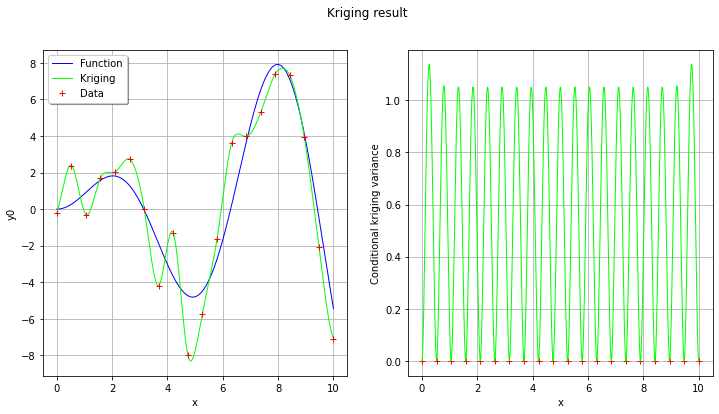

In [7]:
# get the metamodel
krigingMeta = krigingResult.getMetaModel()

n_pts_plot = 1000
x_plot = np.vstack(np.linspace(xmin, xmax, n_pts_plot))
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

# On the left, the function
graph = ref_func.draw(xmin, xmax, n_pts_plot)
graph.setLegends(["Function"])
graphKriging = krigingMeta.draw(xmin, xmax, n_pts_plot)
graphKriging.setColors(["green"])
graphKriging.setLegends(["Kriging"])
graph.add(graphKriging)
cloud = ot.Cloud(x,y)
cloud.setColor("red")
cloud.setLegend("Data")
graph.add(cloud)
graph.setLegendPosition("topleft")
View(graph, axes=[ax1])

# On the right, the conditional kriging variance
graph = ot.Graph("", "x", "Conditional kriging variance", True, '')
# Sample for the data
sample = ot.Sample(n_pt,2)
sample[:,0] = x
cloud = ot.Cloud(sample)
cloud.setColor("red")
graph.add(cloud)
# Sample for the variance
sample = ot.Sample(n_pts_plot,2)
sample[:,0] = x_plot
variance = [krigingResult.getConditionalCovariance(xx)[0, 0] for xx in x_plot]
sample[:,1] = ot.Sample(variance,1)
curve = ot.Curve(sample)
curve.setColor("green")
graph.add(curve)
View(graph, axes=[ax2])

fig.suptitle("Kriging result");

## Display the confidence interval

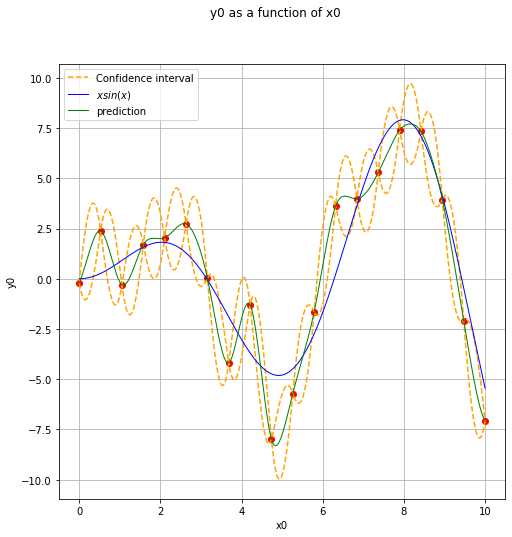

In [8]:
level = 0.95
quantile = ot.Normal().computeQuantile((1-level)/2)[0]
borne_sup = np.hstack(krigingMeta(x_plot)) + quantile * np.sqrt(variance)
borne_inf = np.hstack(krigingMeta(x_plot)) - quantile * np.sqrt(variance)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, y, ('ro'))
ax.plot(x_plot, borne_sup, '--', color='orange', label='Confidence interval')
ax.plot(x_plot, borne_inf, '--', color='orange')
View(ref_func.draw(xmin, xmax, n_pts_plot), axes=[ax], plot_kwargs={'label':'$x sin(x)$'})
View(krigingMeta.draw(xmin, xmax, n_pts_plot), plot_kwargs={'color':'green', 'label':'prediction'}, axes=[ax])
legend = ax.legend()
ax.autoscale()

## Generate conditional trajectories

In [9]:
# support for trajectories with training samples removed
values = np.linspace(0, 10, 500)
for xx in x:
    if len(np.argwhere(values==xx)) == 1:
        values = np.delete(values, np.argwhere(values==xx)[0, 0]) 

In [10]:
# Conditional Gaussian process
krv = ot.KrigingRandomVector(krigingResult, np.vstack(values))
krv_sample = krv.getSample(5)

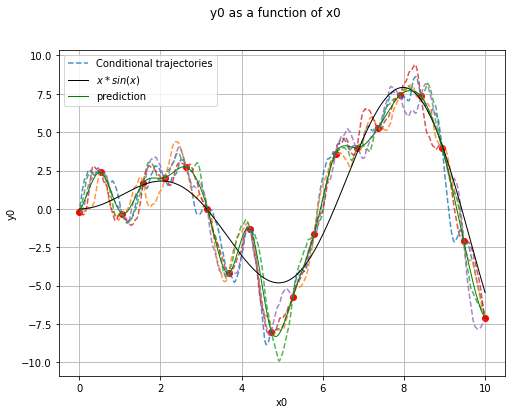

In [11]:
x_plot = np.vstack(np.linspace(xmin, xmax, n_pts_plot))
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, ('ro'))
for i in range(krv_sample.getSize()):
    if i == 0:
        ax.plot(values, krv_sample[i, :], '--', alpha=0.8, label='Conditional trajectories')
    else:
        ax.plot(values, krv_sample[i, :], '--', alpha=0.8)
View(ref_func.draw(xmin, xmax, n_pts_plot), axes=[ax],
     plot_kwargs={'color':'black', 'label':'$x*sin(x)$'})
View(krigingMeta.draw(xmin, xmax, n_pts_plot), axes=[ax],
     plot_kwargs={'color':'green', 'label':'prediction'})
legend = ax.legend()
ax.autoscale()

## Validation

In [12]:
n_valid = 10
x_valid = ot.Uniform(xmin, xmax).getSample(n_valid)
if with_error:
    X_valid = ot.Sample(x_valid)
    X_valid.stack(ot.Normal(0.0, 1.5).getSample(n_valid))
    y_valid = np.array(ref_func_with_error(X_valid))
else:
    y_valid = np.array(ref_func(X_valid))

In [13]:
validation = ot.MetaModelValidation(x_valid, y_valid, krigingMeta)
validation.computePredictivityFactor()

0.861245936492467

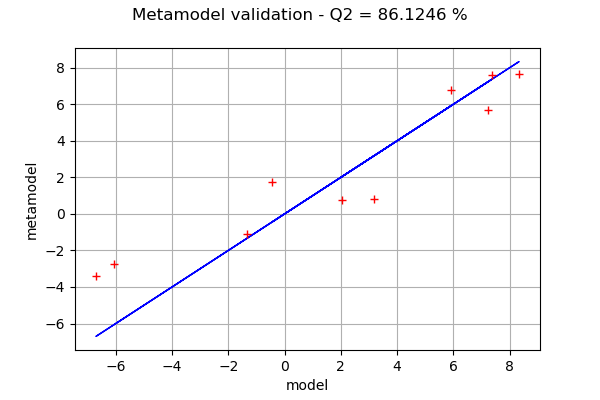

In [14]:
validation.drawValidation()

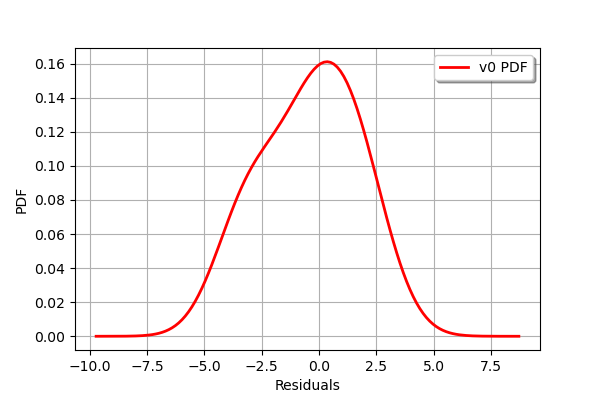

In [15]:
graph =validation.getResidualDistribution().drawPDF() 
graph.setXTitle("Residuals")
graph